# Plan og arbeidsflyt i GiHub



1. åpne terminalen i mappen lokalt på deres maskin.
2. kjør kommandoene:

git fetch origin $$$$
git pull origin master$$$$

3. Da vil master-branchen oppdateres lokalt hos dere. Nå skal dere lage en branch hvor den nye koden skal skrives. Velg et navn til branchen (gjerne noe deksriptivt), og kjør kommandoen.

$$$$
git checkout -b NAVN $$$$

3. hvor NAVN er navnet dere valgte (NAVN må være uten mellomrom). Dere må også passe på å ikke lage branch-navn som krasjer (altså, hvis både trond og ola lager branchen 'feature', så vil alt bli ødelagt :) )



4. Nå kan dere gjøre endringer fritt. Pass dog på at dere skriver i den SAMME cellen i jupyter. Dette er viktig. Vi tildeler celler sammen, så ikke start å jobbe før vi har blitt enig om celler. 

5. Når dere er ferdig å jobbe, kjør kommandoene:

$$$$
git add .$$$$
git commit -m "MELDING"$$$$

5. og bytt ut MELDING med en myyye mer deskriptiv mld. Dette er også viktig, da denne meldingen kan brukes til å finne tilbake til gammel kode

6. dytt koden til github ved å kjøre kommandoen: 

$$$$
git push origin NAVN $$$$

6. hvor NAVN igjen er navnet på branchen

7. send mld til oss andre hvis dere har pushet en branch til github. Da må vi nemlig gå inn på github og gjennomføre en "Pull-request".

# Prosjekt 1 - bio


**MÅ ORDNES:**\
**legge inn alle bilder som vedlegg**\
**finne på noe lurt så gif ikke trenger å være lagra på pc...**


**


## Contents
* [Introduction](#intro)
* [Model and assumptions](#model)
* [Monomer simulation](#monomer)
* [Cluster formation](#cluster)
* [Polymer simulation](#polymer)
* [Aggregate formation](#aggregate)
* [Conclusion](#conclusion)

## Introduction <a class="anchor" id="intro"></a>

Organelles are tiny structures with one or more specific functions inside of a cell. 
Some organelles have a lipid membrane which separates the interior from the rest of the cell, while others have no membrane. 
Nucleoli are an example of membrane-less organelles. 
They are composed of RNA and proteins, which are both examples of biopolymers. 
That is, molecules containing repeating units. 
These repeating units are known as monomers and are bound together by covalent bonds. 
\
\
The goal of this project is to study the formation of membrane-less organelles such as nucleoli through electrostatic interactions between monomers and polymers. 
We will study both monomer and polymer systems numerically by running a computer simulation. **(burde vi si mer om hvordan?)** We want to find out how the energy develops over time and how long it takes for the system to reach its equilibrium, in addition to how parameters such as temperature and polymer size affects the system. 

## Model and assumptions <a class="anchor" id="model"></a>

When simulating the monomer system, we make **# number of assumptions** the assumption that there are no interactions between any two monomers that are not directly adjacent to each other vertically or horizontally. This is because long range interactions between the monomers are reduced by the solvent screening the electric field. In addition, the Coulomb forces are proportional to $1/r^2$. Therefore, the long range interactions between the monomers can be neglected. This means that when calculating the energy of the system we only need to take in to account neighboring monomers. The energy stored in a bond between two monomers can be calculated by the formula (formell). To find the total energy of the system we need to sum the energy between all neighboring monomers.
\
\




In [1]:
## Libraries to make fast code
from numba import jit
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

# Remove annoying deprecation warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

## Libraries for maths, plotting and animation
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as c
import matplotlib.animation
import scipy.constants as sc
from IPython.display import HTML, clear_output

## Library for status bar
from tqdm.notebook import tqdm

## Importing and defining the necessary constants
bolzmann = sc.Boltzmann 
epsilon0 = sc.epsilon_0
elemcharge = sc.e
epsilonr = 78
a = 23.0e-6

# This will be our unit of energy
alpha = sc.e **2 / (4 * np.pi * epsilon0*epsilonr*a**2)

# The constant in the boltzman factor-exponent
k_energy = alpha/bolzmann

In [2]:
## Function that generates N*N grid with 2M monomers
@jit(nopython=True)
def generate_grid_of_monomers(N, M):
    """
        input: int N, int M: N is the grid-dimension. M is the number of positive and negative monomers
        output: N x N grid of i2-integers. 2M of which is either positive ore negative, the rest 0
    """
    grid = np.zeros((N, N), dtype=np.dtype('i2'))
    
    num = M
    while (num > 0):
        i = np.random.randint(0, N)    #choose random coordinates to place monomer
        j = np.random.randint(0, N)
        if grid[i][j] == 0:            #place monomer if there isn't one there already
            grid[i][j] = -num
            num -= 1                   #decrement inside if, ensuring M monomers int total are placed
            
    num = M
    while (num > 0):
        i = np.random.randint(0, N)
        j = np.random.randint(0, N)
        if grid[i][j] == 0:
            grid[i][j] = num
            num -= 1
    
    return grid

In [3]:
## Colormaps for visualising our grid
def cMap_green_purple(lenght):
    color_list = []
    for i in range(0, lenght):
        color_list.append(np.array([120 + i*100/lenght, 28, 178]) / 255) # purple
    color_list.append(np.array([159, 220, 233]) / 255)                               # blue
    for i in range(0, lenght):
        color_list.append(np.array([11, 138 + i*100/lenght, 0]) / 255)   # green
    return c.ListedColormap(color_list)

def cMap_brown(lenght):
    color_list = []
    color_list.append(np.array([159, 220, 233]) / 255)                               # blue
    for i in range(0, lenght):
        color_list.append(np.array([255 - i*200/lenght, 200 - i*200/lenght, 150 - i*150/lenght]) / 255)   # orange
    return c.ListedColormap(color_list)

## Function that plots and saves the grid
def visualize_grid(grid, file_title = False, figure_title = False, sign_only = True, 
                   cMap_function = cMap_green_purple, title_size = 30, fig_size = (10, 10)):
    """
        input: grid, 2d grid of signed integers
        function: visualizing the signed grid, different color for positive, negative and zero
        return: none
    """
    # make grid have only -1, 0 and 1. [::-1,] flips the rows
    if sign_only:
        grid = np.sign(grid)
    grid = grid[::-1,]
    lenght_color_array = grid.max() 
    cMap = cMap_function(lenght_color_array)
        
    # plotting as a colormesh
    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    ax.pcolormesh(grid, cmap = cMap)
    plt.axis('off')
    
    # adding titles and saving file    
    if figure_title:
        plt.title(figure_title, size = title_size)
    if file_title:
        fig.savefig(f'images/{file_title}.png') # save first frame  
    
def animate_grid(grid_list, gif_name, ms_between_frames = 10, sign_only = True):
    """
        input: list of N*N-grids, string gif_name, ms between frames, option to toggle different colors
        output: saves
    """ 
    # generate colormap. Flip grid.
    if sign_only:
        grid_list = [np.sign(grd) for grd in grid_list]
    grid_list = [grd[::-1,] for grd in grid_list]
    lenght_color_array = grid_list[0].max()
    cMap = cMap_green_purple(lenght_color_array)
    
    # create figure and remove axis
    fig, ax = plt.subplots(figsize = (6, 6))
    plt.axis('off')
    
    # prevent duplicate animation figure
    clear_output()
    
    # for some reason the function doesn't distinguish small numbers... This is a fix
    grid_list = [grd * 1000 for grd in grid_list]
    
    # create objects for the graphs that will be updated every frame
    cax = ax.pcolormesh(grid_list[0], cmap=cMap)
    fig.savefig(f'animations/{gif_name}_0.png') # save first frame      
    
    # call this function for every frame in the animation
    def animate(i):
        # replace previous data
        cax.set_array(grid_list[i])
        if i % 1000 == 0:
            print(i)
        
    # create matplotlib animation object
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(grid_list), repeat=False, interval = ms_between_frames)
    ani.save(f'animations/{gif_name}.gif')
    fig.savefig(f'animations/{gif_name}_1.png') # save last frame

Now we will implement energy function ...

### 1d

$$V_{kl} = ... = $$

Energy given by ... approximations ...:

$$V_{kl} = \begin{cases} w_k w_l α & \text{if } \vec{r}_k \text{ and } \vec{r}_l \text{ are NN,}\\ 
0 & \text{otherwise}.\end{cases}$$

For en rute i griden er altså energien gitt som:

$$V_{rute} = \sum_{NN} w_{rute}w_{NN}\alpha = w_{rute}\alpha\sum_{NN}w_{NN}$$
Alt vi trenger er altså nettoladning til naboer $\cdot$ ladning til ruta $\cdot$ en konstant.
For å få tall av fin størrelsesorden innfører vi den dimmensjonsløse energistørrelsen $V/\alpha$.

In [4]:
##1d
import time
@jit(nopython=True)
def total_energy(grid):
    """
        input: grid of size (N x N)
        output: total energy of grid / alpha
    """
    # create grid of charge signs
    sign_grid = np.sign(grid)
    E = sign_grid[0] * 0
    # energy between each square and top, bottom, left and right neighbour
    for row in sign_grid:
        E += row*np.roll(row, -1)
        E += row*np.roll(row, 1)
    for row in sign_grid.T:
        E += row*np.roll(row, -1)
        E += row*np.roll(row, 1)
        
    return 1/2 * np.sum(E) #account for double count


########## LAGRE GRID I 1b og BEREGN ENERGIEN HER!!!!!!!!!

In [5]:
## Define a function that locates the 4 nearest neigbours with periodic boundary contition
@jit(nopython=True)
def nearest_neighbours(i, j, N):
    """
        input: int i, int j, int N. (i, j) is a coordinate in a grid, N is the size of the grid (N x N)
        output: list of the four neighboring points of (i, j). Right side connected to left and top to bottom
    """
    top = [i, (j-1+N)%N]
    right = [(i+1)%N, j]
    bottom = [i, (j +1)%N]
    left = [(i-1 + N)%N, j]
    return [top, right, bottom, left]

In [6]:
N, M = [5, 10, 15], [6, 15, 30]
grid_list = []
for i in range(3):
    n, m = N[i], M[i]
    grid = generate_grid_of_monomers(n, m)
    grid_list.append(grid)
    e = total_energy(grid)
    #visualize_grid(grid, file_title = f"1a_figure_{i+1}", figure_title = f"Grid with N={n}, M={m} and E={e} α", title_size = 30)

Show the figure bla bla bla
Energy can be verified by adding up -1 * # different colored bonds + # same colored bonds


||||
:-------------------------:|:-------------------------:|:-------------------------:
![](https://i.imgur.com/gxThN9U.png)  |  ![](https://i.imgur.com/FZpNxZ7.png)  |  ![](https://i.imgur.com/487hP4I.png)  |



## Monomer simulation <a class="anchor" id="monomer"></a>

In [7]:
##1e
def load_file(Ns, N, M, T, sim_id=""):
    return np.load(f'data/Ns={Ns} N={N} M={M} T={T} {sim_id}.npz')

@jit(nopython=True)
def swap(grid, coord1, coord2):
    x1, y1 = coord1
    x2, y2 = coord2
    
    temp_val = grid[x1][y1]
    grid[x1][y1] = grid[x2][y2]
    grid[x2][y2] = temp_val

@jit(nopython=True)
def move_monomer(coords, direction, grid):
    neighbours = nearest_neighbours(i=coords[0], j=coords[1], N=grid.shape[0])
    move = neighbours[direction]
    move_val = grid[move[0]][move[1]]

    return move, move_val==0

@jit(nopython=True)
def monte_carlo_sim(Ns, N, M, T, grid, fill_grid_list = False):
    e = np.zeros(Ns, dtype="float64") #list of the energies
    E = total_energy(grid)
    e[0] = E
    grids = [grid]
    for i in range(Ns):
        monomer = np.random.randint(1, M+1)
        sign = int(2*(np.random.randint(2) - 0.5))
        monomer_coordinates = np.argwhere(grid==monomer*sign)[0]
        direction = np.random.randint(0, 4) # 0: up, 1: right, 2: down, 3: left
        move, legal_move = move_monomer(monomer_coordinates, direction, grid)
        if legal_move:
            swap(grid, move, monomer_coordinates)
            Enew = total_energy(grid)
            if Enew < E:
                E = Enew 
            elif np.random.random() < np.exp(-k_energy*(Enew-E)/T):
                E = Enew
            else:
                swap(grid, move, monomer_coordinates) # swapping back if the grid shouldnt be updated
        if fill_grid_list:
            grids.append(grid)
        e[i] = E

    return e, grids

N, M = 20, 50
grid = generate_grid_of_monomers(N, M)
Ns = 5000
#e, grids = monte_carlo_sim(Ns, )
#animate_grid()




We can demonstrate the algorithm using our animation function

When it slows down it is checking unaccepted moves

|Grid before alogithm | Grid during algorithm | Grid after algorithm |
:-------------------------:|:-------------------------:|:-------------------------:
![](https://i.imgur.com/Ng1Curt.png)  |  ![](https://i.imgur.com/mtmG5pb.gif)  |  ![](https://i.imgur.com/7zHw3Zs.png)  |



In [8]:
##1f
# Ns = 50000
# N = 15
# M = 25
# T = 200
# grid1 = generate_grid_of_monomers(N, M)
# grid2 = grid1.copy()
# print("grid made")
# e, grids = monte_carlo_sim(Ns, N, M, T, grid1, fill_grid_list = True)
# print("simulation done")
# np.savez('T200+grids.npz', e=e, grids=grids)
# print("file saved")

# T = 500
# e, grids = monte_carlo_sim(Ns, N, M, T, grid2, fill_grid_list = True)
# print("simulation done")
# np.savez('T500+grids.npz', e=e, grids=grids)
# print("file saved")

def plot_function(x_vals_list, y_vals_list, file_title, errorbars = np.array([0]), title = "", 
                  xlabel = "", ylabel = "", fig_size = (9, 5), title_scale_factor = 80,
                  labels = False, loc = "upper right"):
    fig = plt.figure(figsize=fig_size)        
    if errorbars.any():
        plt.errorbar(x_vals_list[0], y_vals_list[0], yerr = errorbars)
    else:
        fig = plt.figure(figsize=fig_size)
    for i in range(len(y_vals_list)):
        if labels:
            plt.plot(x_vals_list[i], y_vals_list[i], label = labels[i])
        else:
            plt.plot(x_vals_list[i], y_vals_list[i])
    title_size = int(title_scale_factor * fig_size[0] / len(title))
    plt.title(title, size = title_size)
    label_size = int(2/3 * title_size)
    plt.xlabel(xlabel, size = label_size)
    plt.ylabel(ylabel, size = label_size)
    if labels:
        plt.legend(loc = loc)
    fig.savefig(f'images/{file_title}.png') # save first frame  

# data200 = np.load('T200+grids.npz')
# data500 = np.load('T500+grids.npz')

# plot_function([np.arange(1, 50001, 1), np.arange(1, 50001, 1)], [data200['e'], data500['e']], 
#                "EnergyDev50000", title = "Energy development", title_scale_factor=55,
#               xlabel = "iterations", ylabel = r"E / $\alpha$", fig_size = (8, 4),
#               labels = ["T = 200 K", "T = 500 K"], loc = "lower left")


\
\
**MÅ FINNE EN MÅTE Å "DETERMINE VISUALLY NUMBER OF STEPS!!!"**
\
\
![](https://i.imgur.com/sH4a4AL.png)
\
\

From the plot we can se that it takes approximately **x_1** MC steps for the system with temperature **T_1** to reach its equilibrium, while the system with temperature **T_2** takes **x_2** steps to reach equilibrium. From our implementation of the MC algorithm we can se that a higher temperature increases the probability of a monomer making a move which increases the total energy of the system. This explains why the energy of system 2 varies more after reaching its equilibrium. **(Mer om hvorfor de er forskjellige, og hvorfor det stemmer med fysikken.)**\
\
\
\
\
**ENERGY MINIMA!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!**
\
\
\
\
\
\

In [9]:
#temperatures = np.li

## Cluster formation <a class="anchor" id="cluster"></a>

In [10]:
##1g
@jit(nopython=True)
def add_to_cluster(i, j, num, grid, cluster_grid):
    #adds index i,j and all connected monomers to cluster identified by num on the cluster_grid
    if cluster_grid[i][j] == 0 and grid[i][j] != 0:
        cluster_grid[i][j] = num
        neighbours = nearest_neighbours(i, j, len(grid))
      
        for neighbor in neighbours: 
            add_to_cluster(neighbor[0],neighbor[1], num, grid, cluster_grid)
        
       
                
@jit(nopython=True)
def get_cluster_grid(grid):
    #input: grid is a grid of monomers of which you want to generate a corresponding cluster grid
    #output: grid where all monomers belonging to the same cluster are represented by the a unique positive number
   
    cluster_grid = np.zeros((len(grid), len(grid)), dtype=np.dtype('i2'))
    num = 1
                                      
    for i in range(len(grid)):
        for j in range(len(grid)):
            if cluster_grid[i][j]== 0 and grid[i][j] != 0:
                add_to_cluster(i, j, num, grid, cluster_grid)
                num += 1
    
    return cluster_grid, num-1  

# data200 = np.load('T200+grids.npz')
# data500 = np.load('T500+grids.npz')

# plot_function([np.arange(1, 50001, 1), np.arange(1, 50001, 1)], [data200['e'], data500['e']], 
#                "EnergyDev50000", title = "Energy development", title_scale_factor=55,
#               xlabel = "iterations", ylabel = r"E / $\alpha$", fig_size = (8, 4),
#               labels = ["T = 200 K", "T = 500 K"], loc = "lower left")

# data200 = np.load('T200+grids.npz')
# final_grid200 = data200['grids'][-1]
# visualize_grid(final_grid200, file_title = "FinalGridT200")

# cluster_grid200 = get_cluster_grid(final_grid200)[0]
# visualize_grid(cluster_grid200, file_title = "Cluster_FinalGridT200", cMap_function = cMap_brown, sign_only = False)

|Monomer grid | Cluster grid |
:-------------------------:|:-------------------------:|
![](https://i.imgur.com/CNhBHEA.png)  |  ![](https://i.imgur.com/57cCYfz.png)  |



1h

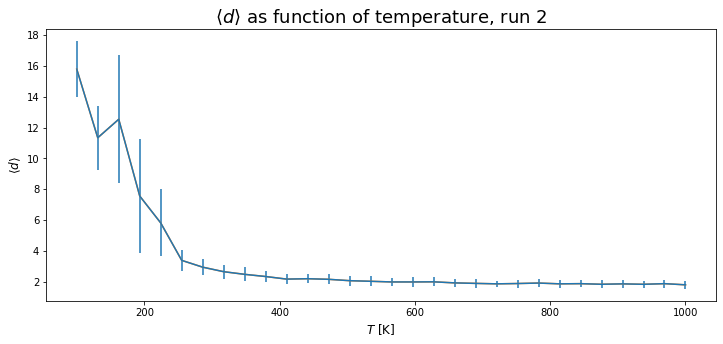

In [11]:
#1h

def load_avg_d(temps, s=1/200, C=10000, t_max=100000, n=100, t_r=1000):
    return np.load(f'data/davg/temps={temps} s={s} C={C} tmax={t_max} n={n} tr={t_r}.npz')
    
@jit(nopython=True)
def average_d_sim(N, M, temps, s=1/200, C=10000, t_max=100000, n=100, t_r=1000):
    avg_dist = np.zeros(len(temps), dtype="float64")
    std_dev  = np.zeros(len(temps), dtype="float64")
    for j in range(len(temps)):
        print(f"Working on temperature {j+1}/{len(temps)}")
        T = temps[j]
        grid = generate_grid_of_monomers(N, M)
        t_equil = t_max * np.exp(-s*(T - temps[0])) + C
        Ns = int(t_equil)
        monte_carlo_sim(Ns, N, M, T, grid)
        d_avg = np.zeros(n, dtype="float64")
        for i in range(n):
            monte_carlo_sim(t_r, N, M, T, grid)
            d_avg[i] = 2*M/get_cluster_grid(grid)[1]
            
        avg_dist[j] = sum(d_avg) / n
        std_dev[j]  = np.std(d_avg)
    return avg_dist, std_dev

N=15
M=25

NN = 30
# temperatures = np.linspace(100, 1000, NN)
# d, std = average_d_sim(N, M, temperatures, n=100)
# np.savez(f"data/monomer_d_sim_{NN}_1", T=temperatures, d=d, std=std)

data = np.load(f"data/monomer_d_sim_{NN}_1.npz")
T = data['T']
d = data['d']
std = data['std']

plot_function([T], [d], f"d_and_temp_{NN}", title = r"$\langle d \rangle$ as function of temperature, run 2", 
            xlabel = r"$T$ [K]", ylabel = r"$\langle d \rangle$", fig_size = (12, 5), errorbars = std)

\


\\

\
\
\
\
\


<td style="width: 50%"> <img src="https://i.imgur.com/wxFlsqC.png" alt="Drawing" /> </td>
<td style="width: 50%"> <img src="https://i.imgur.com/4R76zXZ.png" alt="Drawing" /> </td>



**NEED ONE MORE, compare, discrepancy at low T +++**


As we can see from the plot, <d> is larger at lower temperatures. This is because when the temperature is lower, the probability of making a move that increases the energy of the system is lower. A move that would increase the energy of the system would be a monomer disconnecting from a cluster. At higher temperatures the probability of making such a move is higher, therefore explaining the discrepancy between <d> at the different temperatures. (var noen av resultatene overraskende ?). At lower temperatures the probability of monomers breaking off from a cluster and forming a new cluster is smaller, because such a move would temporarily increase the energy of the system. This is more likely to happen at higher temperatures where the probability of increasing the energy is larger. Therefore, the results are more dependent on the initial conditions, which are randomized, when the temperature is lower. This can explain why the discrepancy between the simulations is larger at lower temperatures. 

**DISCUSS CHOICE OF N, surprising results, **

## Polymer simulation <a class="anchor" id="polymer"></a>

2a fra nå av er a = 91 $\mu m$\
\
\
\
When studying the polymer system, we will again make the assumption that there are no interactions between monomers not directly adjacent to each other. In addition, all interactions between monomers belonging to the same polymer will be set to zero, as it will make the simulation less computationally demanding. We will also assume that polymers cannot be broken, meaning that there will always be a path between any two monomers belonging to the same polymer, and this path contains only monomers of that same polymer. 


In [12]:
a = 91.0e-6
alpha = sc.e **2 / (4 * np.pi * epsilon0*epsilonr*a**2)
k_energy = alpha/bolzmann

@jit(nopython=True)
def build_polymer(grid, N, L, num):
    # next we place L-1 monomers around it
    num2 = L - 1
    max_iter = N*N*N
    while (num2 > 0):
        i2 = np.random.randint(0, N) 
        j2 = np.random.randint(0, N)
        neighbours   = nearest_neighbours(i2, j2, N)
        neighbourNum = [grid[neigh[0]][neigh[1]] for neigh in neighbours]
        if grid[i2][j2] == 0 and num in neighbourNum:
            grid[i2][j2] = num
            num2 -= 1
        else:
            max_iter -= 1
            if (max_iter == 0):
                return False
    return True

@jit(nopython=True)
def generate_grid_of_polymers(N, M, L):
    """
        input: int N, M, L: N is grid-dimension. 
        M is #polymers. L is multivalency
        output: N x N grid of polymers.
    """
    grid = np.zeros((N, N), dtype=np.dtype('i2'))
    
    num = M
    while (num > 0):
        i = np.random.randint(0, N) # choose random coordinates to place first monomer
        j = np.random.randint(0, N)
        if grid[i][j] == 0:         # place monomer if there isn't one there already
            grid[i][j] = -num
            if build_polymer(grid, N, L, -num):
                num -= 1 #decrement inside if, ensuring M polymers in total are placed
            else:
                for monomer in np.argwhere(grid==-num):
                    i, j = monomer
                    grid[i][j] = 0

                    
    num = M
    while (num > 0):
        i = np.random.randint(0, N)
        j = np.random.randint(0, N)
        if grid[i][j] == 0:
            grid[i][j] = num
            if build_polymer(grid, N, L, num):
                num -= 1
            else:
                for monomer in np.argwhere(grid==num):
                    i, j = monomer
                    grid[i][j] = 0
    
    return grid

In [13]:
@jit(nopython=True)
def polymer_total_energy(grid):
    N = grid.shape[0]
    
    E = 0
    for i in range(N):
        for j in range(N):
            neighbours = nearest_neighbours(i, j, N)
            current_cluster_val = grid[i][j]
            for neighbor in neighbours:
                xcoord, ycoord = neighbor
                if grid[xcoord][ycoord] != current_cluster_val:
                    E += np.sign(current_cluster_val*grid[xcoord][ycoord])
    return E/2

grid = generate_grid_of_polymers(6, 2, 5)
print(grid)
print(polymer_total_energy(grid))

[[ 0  2  2  0  0  0]
 [ 2  2 -1 -1 -1 -1]
 [-2  1  1  1  0 -1]
 [-2  0  0  1  1 -2]
 [-2  0  0  0  0 -2]
 [ 0  2  0  0  0  0]]
-5.0


In [14]:
# N, M, L = [10, 15, 25], [2, 4, 6], [10, 20, 30]
# for i in range(3):
#     n, m, l = N[i], M[i], L[i]
#     grid = generate_grid_of_polymers(n, m, l)
#     e = polymer_total_energy(grid)
#     visualize_grid(grid, file_title = f"2a_figure_{i+1}", figure_title = f"Grid with N={n}, M={m}, L={l} and E={e} α", 
#                    title_size = 25, sign_only = False)

||||
:-------------------------:|:-------------------------:|:-------------------------:
![](https://i.imgur.com/o3kthLy.png)  |  ![](https://i.imgur.com/7heNuoA.png)  |  ![](https://i.imgur.com/lg0OIQi.png)  |

In [15]:
@jit(nopython=True)
def rigid_move_polymer(direction, num, grid):
    #input: direction represented by an int, num is a unique int identifying the polymer, and the grid of polymers
    size = grid.shape[0]
    polymer = np.argwhere(grid==num)
    for monomer in polymer: 
        neighbor = nearest_neighbours(monomer[0], monomer[1], size)[direction]
        i = neighbor[0]
        j = neighbor[1]
        
        if (grid[i][j] != 0 and grid[i][j] != num):
            return False
    
    for monomer in polymer:
        neighbor = nearest_neighbours(monomer[0], monomer[1], size)[direction]
        i = neighbor[0]
        j = neighbor[1]
        
        grid[i][j] += num
        grid[monomer[0]][monomer[1]] -= num
                     
    return True

In [42]:
@jit(nopython=True)
def monte_carlo_sim_polymer(Ns, N, M, T, grid, move_function, fill_grid_list = False):
    e = np.zeros(Ns, dtype="float64") #list of the energies
    E = polymer_total_energy(grid)
    e[0] = E
    grids = [grid]
    for i in range(Ns):
        polymer = int(2*(np.random.randint(2) - 0.5)) * np.random.randint(1, M+1) # sign * num
        direction = np.random.randint(0, 4) # 0: up, 1: right, 2: down, 3: left
        grid0 = grid.copy()
        legal_move = move_function(direction, polymer, grid)
        if legal_move:
            Enew = polymer_total_energy(grid)
            if Enew < E:
                E = Enew 
            elif np.random.random() < np.exp(-k_energy*(Enew-E)/T):
                E = Enew
            else:
                grid = grid0
        e[i] = E
        if fill_grid_list:
            grids.append(grid)

    return e, grids

In [17]:
@jit(nopython=True)
def contains(polymer, monomer0):
    for monomer in polymer:
        if monomer[0] == monomer0[0] and monomer[1] == monomer0[1]:
            return True
    return False

@jit(nopython=True)
def depth_first_search(monomer, num, grid, visited, index):
    if contains(visited, monomer) or index == visited.shape[0]:
        return
    visited[index[0]] = monomer
    index += 1
    for neighbour in nearest_neighbours(monomer[0], monomer[1], grid.shape[0]):
        if grid[neighbour[0]][neighbour[1]] == num:
            depth_first_search(neighbour, num, grid, visited, index)
    return

@jit(nopython=True)
def polymer_is_broken(polymer, num, grid, L):
    visited = -np.ones(polymer.shape, dtype=np.dtype('i2'))
    index = np.zeros(1, dtype=np.dtype('i2'))
    depth_first_search(polymer[0], num, grid, visited, index)
    return index[0] != L
    
@jit(nopython=True)
def medium_flex_move(direction, num, grid):
    N = grid.shape[0]
    polymer = np.argwhere(grid==num)
    L = polymer.shape[0]
    neighbours = np.zeros(polymer.shape, dtype=np.dtype('i2'))
    illegals = np.zeros(N)
    row_to_move = direction%2
    
    for i in range(L):
        monomer = polymer[i]
        neighbours[i] = nearest_neighbours(monomer[0], monomer[1], N)[direction]
        x, y = neighbours[i]
        if grid[x][y] != 0 and grid[x][y] != num:
            illegals[neighbours[i][row_to_move]] = 1
    
    
    for monomer, neighbour in zip(polymer, neighbours):
        index = monomer[row_to_move]
        if illegals[index] == 0:
            i, j = monomer
            x, y = neighbour
            grid[i][j] -= num
            grid[x][y] += num
    
    new_polymer = np.argwhere(grid==num)
    if polymer_is_broken(new_polymer, num, grid, L):
        for monomer in new_polymer:
            grid[monomer[0]][monomer[1]] = 0
        for monomer in polymer:
            grid[monomer[0]][monomer[1]] = num
        return False
    
    return True

In [26]:
L = 12
M = 4
T = 200 * 1/16
N = 15
Ns = 30000
grid1 = generate_grid_of_polymers(N, M, L)
grid2 = grid1.copy()
print(1)
e1, grids1 = monte_carlo_sim_polymer(Ns, N, M, T, grid1, rigid_move_polymer, fill_grid_list=True)
print(2)
np.savez('data/RigidPolymerGridsColdAF.npz', e=e1, grids=grids1)
print(3)
e2, grids2 = monte_carlo_sim_polymer(Ns, N, M, T, grid2, medium_flex_move, fill_grid_list=True)
print(4)
np.savez('data/FlexPolymerGridsColdAF.npz', e=e2, grids=grids2)

1
2
3
4


MovieWriter ffmpeg unavailable; using Pillow instead.


0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000


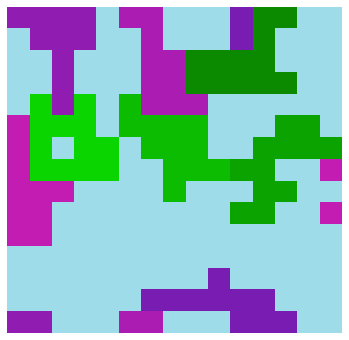

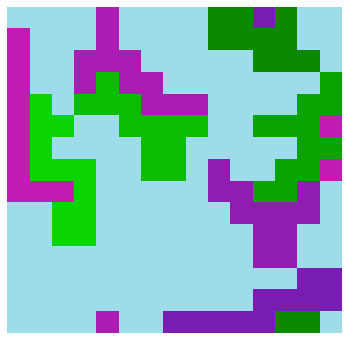

In [27]:
data1 = np.load('data/RigidPolymerGridsColdAF.npz')
data2 = np.load('data/FlexPolymerGridsColdAF.npz')
grids1 = data1['grids']
grids2 = data2['grids']

animate_grid(grids1, 'RigidAnim30000ColdAF', sign_only = False)
animate_grid(grids2, 'FlexAnim30000ColdAF', sign_only = False)


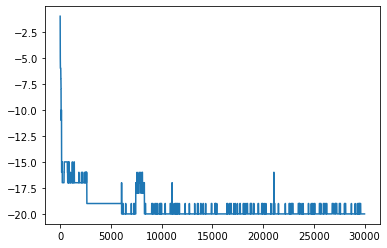

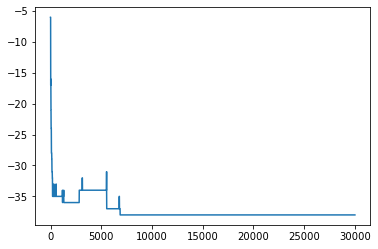

In [28]:
data1 = np.load('data/RigidPolymerGridsColdAF.npz')
data2 = np.load('data/FlexPolymerGridsColdAF.npz')
e1 = data1['e']
e2 = data2['e']

plt.plot(e1)
plt.show()
plt.plot(e2)

1.0
1.0
0.523741211804855
0.7720522615790711
0.878665045156043
1.2952491039333394
0.5960646946093585
1.0
1.4741101982761982
0.6783753352831997
0.7720522615790711
0.7720522615790711
1.0
0.878665045156043
1.2952491039333394
0.7720522615790711
1.138090112395912
1.6776702412401185
1.2952491039333394
0.7720522615790711
0.4601930955205936
1.0
1.2952491039333394
1.0
0.878665045156043
1.0
2.1730008766618925
1.0
1.0
0.5960646946093585
1.2952491039333394
1.909339913416243
1.0
0.7720522615790711
1.138090112395912
0.7720522615790711
0.878665045156043
1.909339913416243
0.7720522615790711
0.878665045156043
0.6783753352831997
0.6783753352831997
1.4741101982761982
1.909339913416243
0.6783753352831997
0.6783753352831997
0.5960646946093585
1.138090112395912
1.4741101982761982
1.0
0.6783753352831997
0.7720522615790711
0.523741211804855
1.0
0.7720522615790711
1.0
0.6783753352831997
1.0
1.0
0.6783753352831997
1.909339913416243
0.523741211804855
1.0
1.2952491039333394
1.0
1.4741101982761982
0.67837533528319

0.523741211804855
1.138090112395912
0.7720522615790711
1.2952491039333394
0.7720522615790711
0.7720522615790711
1.0
1.138090112395912
0.878665045156043
1.2952491039333394
0.5960646946093585
1.2952491039333394
0.878665045156043
1.138090112395912
0.878665045156043
1.2952491039333394
0.523741211804855
1.0
0.6783753352831997
1.0
0.878665045156043
0.878665045156043
0.878665045156043
1.138090112395912
0.523741211804855
0.878665045156043
1.138090112395912
1.0
0.5960646946093585
1.2952491039333394
1.138090112395912
1.138090112395912
1.0
0.878665045156043
1.6776702412401185
1.0
0.878665045156043
0.7720522615790711
1.2952491039333394
0.878665045156043
0.878665045156043
0.7720522615790711
0.6783753352831997
1.138090112395912
2.473070811956548
1.2952491039333394
0.878665045156043
1.138090112395912
0.7720522615790711
0.7720522615790711
1.0
1.2952491039333394
0.878665045156043
1.2952491039333394
0.523741211804855
1.0
1.138090112395912
0.878665045156043
1.0
1.0
0.878665045156043
1.0
1.138090112395912

1.0
0.7720522615790711
0.878665045156043
1.0
1.138090112395912
1.4741101982761982
1.0
0.5960646946093585
1.138090112395912
1.909339913416243
0.878665045156043
1.138090112395912
0.878665045156043
0.6783753352831997
0.878665045156043
0.878665045156043
1.138090112395912
1.6776702412401185
1.909339913416243
0.5960646946093585
0.6783753352831997
0.6783753352831997
0.878665045156043
1.4741101982761982
1.2952491039333394
0.523741211804855
0.878665045156043
0.523741211804855
1.0
0.5960646946093585
1.0
1.0
0.4601930955205936
1.0
2.1730008766618925
1.0
0.6783753352831997
1.4741101982761982
1.138090112395912
1.138090112395912
1.138090112395912
1.2952491039333394
1.138090112395912
0.4601930955205936
1.6776702412401185
0.523741211804855
0.6783753352831997
1.2952491039333394
1.6776702412401185
0.5960646946093585
1.6776702412401185
1.138090112395912
1.6776702412401185
0.878665045156043
0.5960646946093585
1.138090112395912
1.0
0.878665045156043
0.878665045156043
0.523741211804855
0.5960646946093585
1.

1.138090112395912
0.7720522615790711
0.878665045156043
0.878665045156043
2.1730008766618925
0.878665045156043
0.6783753352831997
0.3552931201597478
1.138090112395912
1.2952491039333394
0.5960646946093585
0.4601930955205936
1.0
0.7720522615790711
1.138090112395912
1.0
1.4741101982761982
0.878665045156043
1.2952491039333394
0.7720522615790711
0.7720522615790711
0.878665045156043
1.0
1.0
0.5960646946093585
1.0
0.878665045156043
1.0
1.0
1.2952491039333394
0.5960646946093585
1.0
1.2952491039333394
0.7720522615790711
1.4741101982761982
0.6783753352831997
0.5960646946093585
1.0
1.0
1.138090112395912
0.7720522615790711
1.138090112395912
1.0
0.878665045156043
1.4741101982761982
1.0
0.6783753352831997
0.6783753352831997
1.4741101982761982
1.2952491039333394
1.4741101982761982
0.6783753352831997
0.6783753352831997
1.138090112395912
1.2952491039333394
1.138090112395912
1.2952491039333394
1.0
0.878665045156043
1.6776702412401185
1.6776702412401185
1.909339913416243
1.138090112395912
0.6783753352831

1.138090112395912
1.0
1.2952491039333394
0.878665045156043
1.0
0.7720522615790711
0.7720522615790711
1.2952491039333394
1.138090112395912
1.2952491039333394
1.0
1.0
1.4741101982761982
0.5960646946093585
1.138090112395912
1.0
0.4601930955205936
1.0
1.0
0.4601930955205936
1.138090112395912
0.878665045156043
0.7720522615790711
1.909339913416243
0.878665045156043
1.2952491039333394
1.2952491039333394
0.4601930955205936
0.4601930955205936
2.1730008766618925
0.5960646946093585
1.138090112395912
0.6783753352831997
1.0
1.0
1.0
1.0
1.0
1.0
0.7720522615790711
0.7720522615790711
1.0
0.7720522615790711
0.878665045156043
1.138090112395912
1.0
1.4741101982761982
1.0
0.3552931201597478
0.7720522615790711
0.4601930955205936
1.138090112395912
0.878665045156043
1.2952491039333394
0.7720522615790711
1.0
1.0
0.878665045156043
1.138090112395912
1.0
1.0
1.2952491039333394
1.2952491039333394
1.0
1.138090112395912
0.7720522615790711
1.0
0.5960646946093585
1.138090112395912
0.878665045156043
1.138090112395912


1.138090112395912
1.0
1.138090112395912
1.6776702412401185
0.7720522615790711
1.4741101982761982
1.0
1.0
0.7720522615790711
0.878665045156043
1.0
0.878665045156043
0.6783753352831997
1.4741101982761982
1.0
1.2952491039333394
0.7720522615790711
1.138090112395912
1.138090112395912
0.878665045156043
1.138090112395912
1.0
1.0
1.0
0.7720522615790711
1.0
1.138090112395912
0.6783753352831997
1.4741101982761982
0.6783753352831997
0.878665045156043
0.878665045156043
1.138090112395912
1.0
2.1730008766618925
1.0
1.0
0.6783753352831997
1.4741101982761982
1.4741101982761982
1.0
0.878665045156043
0.5960646946093585
0.7720522615790711
0.878665045156043
1.2952491039333394
0.878665045156043
0.878665045156043
1.138090112395912
0.5960646946093585
0.878665045156043
0.878665045156043
0.6783753352831997
1.138090112395912
1.2952491039333394
1.2952491039333394
1.6776702412401185
0.7720522615790711
0.523741211804855
0.7720522615790711
1.2952491039333394
0.7720522615790711
0.7720522615790711
1.6776702412401185


0.523741211804855
0.6783753352831997
0.878665045156043
0.878665045156043
0.878665045156043
0.6783753352831997
0.878665045156043
1.4741101982761982
0.6783753352831997
1.138090112395912
0.523741211804855
1.2952491039333394
1.138090112395912
1.138090112395912
1.138090112395912
1.0
0.7720522615790711
1.4741101982761982
1.2952491039333394
1.2952491039333394
1.0
1.138090112395912
0.5960646946093585
0.878665045156043
1.138090112395912
0.878665045156043
1.138090112395912
1.2952491039333394
0.7720522615790711
0.878665045156043
0.5960646946093585
1.2952491039333394
1.0
1.0
1.138090112395912
0.878665045156043
0.7720522615790711
1.0
0.878665045156043
1.4741101982761982
0.878665045156043
0.878665045156043
1.138090112395912
0.878665045156043
0.878665045156043
1.138090112395912
0.878665045156043
1.6776702412401185
1.0
0.523741211804855
1.0
0.6783753352831997
0.5960646946093585
1.138090112395912
1.0
1.2952491039333394
0.878665045156043
0.878665045156043
1.0
1.0
0.878665045156043
1.0
1.138090112395912


1.0
1.0
1.2952491039333394
0.5960646946093585
1.0
1.138090112395912
1.0
0.6783753352831997
1.0
1.138090112395912
1.138090112395912
1.138090112395912
1.138090112395912
0.7720522615790711
1.4741101982761982
0.878665045156043
0.4601930955205936
1.909339913416243
1.2952491039333394
2.1730008766618925
1.0
0.40435558705610164
1.4741101982761982
1.2952491039333394
0.7720522615790711
1.0
1.0
0.4601930955205936
1.0
1.0
1.0
1.0
1.0
1.909339913416243
0.3552931201597478
2.814577438342677
1.138090112395912
1.138090112395912
0.4601930955205936
0.878665045156043
2.1730008766618925
0.7720522615790711
0.5960646946093585
1.0
1.6776702412401185
0.878665045156043
1.0
0.878665045156043
0.6783753352831997
0.4601930955205936
1.138090112395912
1.138090112395912
1.6776702412401185
1.0
0.878665045156043
1.4741101982761982
0.6783753352831997
1.0
0.7720522615790711
1.2952491039333394
0.40435558705610164
0.6783753352831997
0.5960646946093585
0.5960646946093585
0.40435558705610164
0.878665045156043
1.13809011239591

1.0
1.4741101982761982
1.138090112395912
0.7720522615790711
1.138090112395912
1.4741101982761982
0.878665045156043
0.878665045156043
1.138090112395912
0.6783753352831997
1.4741101982761982
0.878665045156043
0.6783753352831997
1.138090112395912
1.2952491039333394
0.6783753352831997
1.0
0.878665045156043
0.878665045156043
0.7720522615790711
0.6783753352831997
1.138090112395912
1.138090112395912
0.7720522615790711
1.0
1.0
1.138090112395912
1.138090112395912
1.0
0.878665045156043
0.878665045156043
1.2952491039333394
0.878665045156043
0.7720522615790711
1.2952491039333394
0.7720522615790711
1.0
1.138090112395912
1.6776702412401185
0.5960646946093585
1.138090112395912
0.7720522615790711
0.878665045156043
0.878665045156043
1.138090112395912
1.138090112395912
1.0
0.878665045156043
1.0
1.6776702412401185
0.7720522615790711
1.2952491039333394
0.7720522615790711
0.6783753352831997
1.4741101982761982
1.138090112395912
1.138090112395912
0.7720522615790711
1.2952491039333394
1.0
0.6783753352831997
1

1.138090112395912
0.6783753352831997
1.4741101982761982
0.7720522615790711
1.2952491039333394
1.2952491039333394
0.878665045156043
1.138090112395912
0.7720522615790711
0.5960646946093585
1.0
1.2952491039333394
1.2952491039333394
1.138090112395912
1.2952491039333394
0.7720522615790711
0.878665045156043
1.2952491039333394
0.878665045156043
0.878665045156043
0.6783753352831997
1.138090112395912
0.7720522615790711
0.4601930955205936
0.5960646946093585
1.2952491039333394
1.138090112395912
1.2952491039333394
0.7720522615790711
1.138090112395912
0.7720522615790711
0.7720522615790711
0.878665045156043
1.2952491039333394
0.7720522615790711
1.0
1.138090112395912
2.1730008766618925
0.4601930955205936
0.878665045156043
1.0
0.4601930955205936
0.7720522615790711
0.878665045156043
0.878665045156043
0.6783753352831997
0.878665045156043
1.138090112395912
1.0
1.138090112395912
1.0
1.2952491039333394
0.878665045156043
1.4741101982761982
1.0
0.7720522615790711
1.4741101982761982
1.138090112395912
0.878665

0.878665045156043
0.6783753352831997
1.2952491039333394
1.0
1.0
1.138090112395912
0.523741211804855
1.2952491039333394
1.0
1.2952491039333394
0.7720522615790711
0.7720522615790711
1.2952491039333394
0.878665045156043
0.878665045156043
0.7720522615790711
1.138090112395912
1.0
1.4741101982761982
1.138090112395912
0.6783753352831997
1.4741101982761982
1.0
1.0
0.878665045156043
0.5960646946093585
0.6783753352831997
0.5960646946093585
1.4741101982761982
1.0
0.878665045156043
0.878665045156043
1.2952491039333394
0.878665045156043
0.6783753352831997
1.4741101982761982
0.6783753352831997
0.6783753352831997
1.138090112395912
1.0
1.0
0.878665045156043
1.138090112395912
1.4741101982761982
1.138090112395912
1.2952491039333394
1.138090112395912
1.138090112395912
0.878665045156043
1.138090112395912
0.878665045156043
0.6783753352831997
1.0
0.878665045156043
0.6783753352831997
0.878665045156043
0.7720522615790711
0.523741211804855
1.0
1.0
1.4741101982761982
1.138090112395912
0.878665045156043
0.878665

0.878665045156043
1.138090112395912
1.0
0.7720522615790711
1.2952491039333394
1.0
0.7720522615790711
0.6783753352831997
0.6783753352831997
0.6783753352831997
1.4741101982761982
0.6783753352831997
1.2952491039333394
0.878665045156043
0.5960646946093585
1.4741101982761982
1.0
1.0
1.2952491039333394
1.0
1.138090112395912
0.7720522615790711
0.6783753352831997
1.2952491039333394
0.878665045156043
1.138090112395912
0.878665045156043
0.7720522615790711
1.0
1.0
0.5960646946093585
0.878665045156043
1.0
1.138090112395912
1.4741101982761982
1.0
0.878665045156043
1.138090112395912
0.7720522615790711
1.138090112395912
1.0
1.138090112395912
1.138090112395912
0.878665045156043
0.7720522615790711
1.0
1.2952491039333394
1.138090112395912
0.7720522615790711
0.7720522615790711
1.138090112395912
0.7720522615790711
0.7720522615790711
1.2952491039333394
1.0
1.0
0.7720522615790711
1.138090112395912
1.138090112395912
0.878665045156043
0.878665045156043
1.138090112395912
1.0
1.0
0.878665045156043
1.0
0.8786650

0.7720522615790711
1.0
1.6776702412401185
1.2952491039333394
0.878665045156043
1.2952491039333394
0.878665045156043
0.5960646946093585
0.7720522615790711
1.138090112395912
0.7720522615790711
0.878665045156043
0.7720522615790711
0.5960646946093585
1.2952491039333394
1.138090112395912
0.5960646946093585
0.7720522615790711
0.5960646946093585
1.6776702412401185
0.7720522615790711
0.5960646946093585
1.2952491039333394
0.6783753352831997
1.0
0.7720522615790711
1.6776702412401185
1.138090112395912
0.878665045156043
1.4741101982761982
1.0
1.138090112395912
0.878665045156043
0.5960646946093585
0.6783753352831997
0.6783753352831997
0.7720522615790711
1.6776702412401185
0.7720522615790711
1.138090112395912
0.878665045156043
1.2952491039333394
1.138090112395912
0.7720522615790711
0.878665045156043
1.0
0.7720522615790711
0.7720522615790711
0.7720522615790711
1.138090112395912
0.878665045156043
1.138090112395912
1.2952491039333394
1.138090112395912
1.138090112395912
1.138090112395912
0.6783753352831

0.40435558705610164
1.138090112395912
1.4741101982761982
0.878665045156043
1.2952491039333394
0.7720522615790711
1.6776702412401185
0.5960646946093585
1.138090112395912
0.878665045156043
1.2952491039333394
0.7720522615790711
0.7720522615790711
1.138090112395912
1.138090112395912
0.878665045156043
0.7720522615790711
1.138090112395912
1.2952491039333394
1.0
0.4601930955205936
0.878665045156043
0.878665045156043
0.878665045156043
0.878665045156043
0.878665045156043
1.0
0.878665045156043
0.7720522615790711
1.138090112395912
0.878665045156043
1.138090112395912
1.138090112395912
1.2952491039333394
1.2952491039333394
1.0
1.0
0.523741211804855
0.7720522615790711
0.7720522615790711
0.878665045156043
1.6776702412401185
1.2952491039333394
0.7720522615790711
0.878665045156043
1.0
1.138090112395912
0.878665045156043
0.6783753352831997
1.4741101982761982
0.6783753352831997
1.138090112395912
0.878665045156043
1.4741101982761982
1.2952491039333394
0.878665045156043
1.0
1.138090112395912
0.772052261579

0.878665045156043
1.2952491039333394
0.6783753352831997
1.0
0.7720522615790711
1.2952491039333394
1.0
1.0
1.0
0.878665045156043
0.523741211804855
0.5960646946093585
1.0
0.878665045156043
1.0
1.0
1.0
1.0
1.138090112395912
1.2952491039333394
1.138090112395912
1.2952491039333394
0.878665045156043
1.0
1.909339913416243
1.2952491039333394
0.878665045156043
0.878665045156043
1.138090112395912
1.0
1.0
0.878665045156043
1.0
1.4741101982761982
1.0
1.0
1.0
1.4741101982761982
0.4601930955205936
1.138090112395912
1.2952491039333394
1.138090112395912
1.0
0.878665045156043
0.5960646946093585
0.6783753352831997
1.4741101982761982
0.878665045156043
1.4741101982761982
0.6783753352831997
0.6783753352831997
1.6776702412401185
0.878665045156043
0.878665045156043
1.6776702412401185
0.6783753352831997
0.878665045156043
1.138090112395912
0.5960646946093585
0.878665045156043
0.6783753352831997
0.7720522615790711
0.878665045156043
1.0
1.2952491039333394
1.4741101982761982
1.138090112395912
1.0
1.47411019827619

0.878665045156043
0.5960646946093585
1.0
0.878665045156043
1.2952491039333394
1.2952491039333394
1.138090112395912
1.6776702412401185
0.5960646946093585
1.138090112395912
0.878665045156043
0.878665045156043
1.138090112395912
1.138090112395912
0.523741211804855
0.878665045156043
0.5960646946093585
1.4741101982761982
0.7720522615790711
0.878665045156043
0.878665045156043
0.7720522615790711
1.138090112395912
1.0
1.138090112395912
2.1730008766618925
0.878665045156043
1.2952491039333394
1.4741101982761982
1.0
1.0
0.523741211804855
1.2952491039333394
0.7720522615790711
0.878665045156043
0.878665045156043
1.2952491039333394
0.6783753352831997
1.138090112395912
1.2952491039333394
0.878665045156043
1.138090112395912
1.0
1.2952491039333394
0.6783753352831997
1.0
1.2952491039333394
1.2952491039333394
1.4741101982761982
0.5960646946093585
0.878665045156043
0.878665045156043
1.2952491039333394
0.878665045156043
1.138090112395912
0.6783753352831997
1.6776702412401185
0.878665045156043
1.0
0.77205226

0.878665045156043
1.0
0.7720522615790711
1.0
1.138090112395912
0.16350344078348458
0.6783753352831997
0.6783753352831997
1.138090112395912
0.6783753352831997
0.878665045156043
1.6776702412401185
0.6783753352831997
1.2952491039333394
1.4741101982761982
1.138090112395912
1.138090112395912
0.4601930955205936
0.878665045156043
1.138090112395912
0.5960646946093585
0.5960646946093585
0.7720522615790711
1.138090112395912
0.878665045156043
2.473070811956548
1.138090112395912
1.4741101982761982
0.878665045156043
1.138090112395912
1.6776702412401185
1.138090112395912
0.4601930955205936
1.4741101982761982
1.138090112395912
1.0
0.7720522615790711
1.2952491039333394
0.523741211804855
0.3552931201597478
1.0
0.7720522615790711
1.4741101982761982
0.5960646946093585
0.7720522615790711
2.1730008766618925
1.0
0.6783753352831997
0.40435558705610164
1.909339913416243
0.7720522615790711
0.7720522615790711
0.7720522615790711
0.7720522615790711
1.2952491039333394
1.138090112395912
0.878665045156043
1.0
1.4741

1.138090112395912
1.4741101982761982
0.274304856942818
0.40435558705610164
0.6783753352831997
2.1730008766618925
0.7720522615790711
0.878665045156043
0.274304856942818
1.138090112395912
1.0
0.523741211804855
1.138090112395912
0.878665045156043
0.7720522615790711
1.138090112395912
1.6776702412401185
2.1730008766618925
1.2952491039333394
0.24102208951218304
0.24102208951218304
1.2952491039333394
1.0
0.523741211804855
1.138090112395912
0.878665045156043
0.878665045156043
1.138090112395912
0.7720522615790711
0.878665045156043
1.138090112395912
0.7720522615790711
0.878665045156043
0.4601930955205936
0.878665045156043
0.878665045156043
1.0
0.878665045156043
1.4741101982761982
1.0
1.0
1.138090112395912
1.138090112395912
1.0
1.138090112395912
0.40435558705610164
1.0
1.2952491039333394
0.7720522615790711
1.2952491039333394
1.4741101982761982
0.7720522615790711
1.6776702412401185
0.878665045156043
1.138090112395912
0.5960646946093585
1.0
1.0
1.0
1.0
0.40435558705610164
0.40435558705610164
0.6783

1.0
1.0
1.6776702412401185
0.5960646946093585
0.7720522615790711
0.31218364546879623
1.138090112395912
1.0
1.0
2.814577438342677
1.0
0.523741211804855
2.1730008766618925
1.4741101982761982
1.138090112395912
0.523741211804855
1.138090112395912
0.878665045156043
0.878665045156043
1.138090112395912
1.0
0.6783753352831997
0.523741211804855
1.138090112395912
3.2032427531504153
1.2952491039333394
0.7720522615790711
1.138090112395912
1.0
1.138090112395912
2.473070811956548
0.6783753352831997
0.4601930955205936
0.7720522615790711
0.274304856942818
1.0
1.2952491039333394
0.878665045156043
0.4601930955205936
0.7720522615790711
1.138090112395912
1.0
0.5960646946093585
1.6776702412401185
1.2952491039333394
0.31218364546879623
2.1730008766618925
1.6776702412401185
1.0
0.7720522615790711
0.7720522615790711
1.0
1.909339913416243
1.138090112395912
0.7720522615790711
1.138090112395912
1.2952491039333394
0.5960646946093585
0.878665045156043
0.523741211804855
0.7720522615790711
1.2952491039333394
0.59606

1.138090112395912
0.7720522615790711
1.0
1.138090112395912
1.4741101982761982
0.7720522615790711
1.0
0.878665045156043
1.2952491039333394
1.6776702412401185
0.6783753352831997
1.0
1.0
1.4741101982761982
1.0
1.138090112395912
1.0
1.138090112395912
0.6783753352831997
0.6783753352831997
1.0
1.0
0.4601930955205936
1.4741101982761982
1.0
0.7720522615790711
1.0
1.0
1.138090112395912
0.21177768516482623
1.2952491039333394
0.5960646946093585
0.40435558705610164
1.2952491039333394
1.2952491039333394
0.5960646946093585
1.138090112395912
1.0
0.3552931201597478
1.0
0.7720522615790711
0.6783753352831997
1.0
1.138090112395912
1.0
1.0
1.138090112395912
0.7720522615790711
1.138090112395912
1.0
0.878665045156043
0.878665045156043
1.0
0.7720522615790711
1.138090112395912
0.6783753352831997
0.878665045156043
1.4741101982761982
1.4741101982761982
1.4741101982761982
1.0
0.6783753352831997
1.4741101982761982
1.138090112395912
0.7720522615790711
1.138090112395912
0.878665045156043
0.5960646946093585
0.772052

1.138090112395912
1.0
0.878665045156043
0.523741211804855
1.909339913416243
1.138090112395912
1.138090112395912
0.878665045156043
1.0
1.138090112395912
1.2952491039333394
0.7720522615790711
0.878665045156043
1.138090112395912
1.0
0.7720522615790711
0.878665045156043
1.2952491039333394
1.138090112395912
0.6783753352831997
0.878665045156043
1.0
1.138090112395912
1.2952491039333394
0.7720522615790711
0.878665045156043
1.0
0.878665045156043
1.4741101982761982
0.878665045156043
1.4741101982761982
0.7720522615790711
1.138090112395912
0.878665045156043
1.6776702412401185
1.2952491039333394
0.7720522615790711
0.6783753352831997
0.4601930955205936
0.878665045156043
0.31218364546879623
1.0
1.4741101982761982
0.878665045156043
0.6783753352831997
1.4741101982761982
2.473070811956548
1.0
1.2952491039333394
1.0
1.0
0.40435558705610164
1.138090112395912
1.0
0.878665045156043
1.0
1.0
1.0
0.40435558705610164
1.0
1.138090112395912
4.148997305699039
1.0
1.0
1.0
1.0
1.0
1.0
0.24102208951218304
1.0
1.0
0.4

0.40435558705610164
1.0
1.138090112395912
4.148997305699039
0.40435558705610164
0.878665045156043
1.138090112395912
2.814577438342677
0.878665045156043
0.6783753352831997
1.4741101982761982
1.0
0.878665045156043
1.6776702412401185
1.0
1.2952491039333394
1.0
1.138090112395912
1.138090112395912
1.4741101982761982
1.0
1.0
1.0
1.138090112395912
1.0
0.7720522615790711
0.274304856942818
1.4741101982761982
0.5960646946093585
1.138090112395912
0.40435558705610164
0.7720522615790711
1.0
0.878665045156043
0.7720522615790711
0.7720522615790711
0.6783753352831997
1.138090112395912
0.6783753352831997
1.909339913416243
3.2032427531504153
1.0
0.5960646946093585
1.4741101982761982
0.523741211804855
0.523741211804855
1.0
0.7720522615790711
0.523741211804855
1.0
1.138090112395912
1.2952491039333394
0.523741211804855
0.523741211804855
0.7720522615790711
1.0
1.0
1.4741101982761982
0.7720522615790711
0.7720522615790711
1.4741101982761982
0.878665045156043
0.6783753352831997
0.6783753352831997
1.29524910393

0.878665045156043
0.5960646946093585
1.2952491039333394
0.878665045156043
1.2952491039333394
0.6783753352831997
0.40435558705610164
0.878665045156043
1.0
0.5960646946093585
0.878665045156043
1.138090112395912
1.4741101982761982
1.2952491039333394
0.7720522615790711
1.138090112395912
0.7720522615790711
1.2952491039333394
1.909339913416243
0.7720522615790711
1.6776702412401185
0.878665045156043
1.138090112395912
0.523741211804855
0.878665045156043
1.0
0.523741211804855
1.4741101982761982
1.0
1.0
0.40435558705610164
0.5960646946093585
1.2952491039333394
2.814577438342677
0.4601930955205936
2.1730008766618925
0.5960646946093585
1.138090112395912
1.4741101982761982
1.138090112395912
0.878665045156043
1.0
1.0
1.0
1.0
0.5960646946093585
1.138090112395912
1.0
0.7720522615790711
1.0
0.3552931201597478
1.0
0.6783753352831997
1.0
1.0
0.6783753352831997
0.6783753352831997
1.0
1.0
0.5960646946093585
1.4741101982761982
1.0
1.0
0.523741211804855
0.6783753352831997
1.0
0.878665045156043
1.138090112395

1.138090112395912
0.878665045156043
0.7720522615790711
0.878665045156043
0.6783753352831997
1.0
0.7720522615790711
1.0
0.7720522615790711
1.138090112395912
1.138090112395912
1.138090112395912
1.138090112395912
1.0
0.878665045156043
1.2952491039333394
0.6783753352831997
1.138090112395912
0.878665045156043
1.0
2.1730008766618925
1.2952491039333394
1.0
0.3552931201597478
1.0
0.4601930955205936
1.138090112395912
1.2952491039333394
0.878665045156043
0.6783753352831997
0.878665045156043
1.138090112395912
0.523741211804855
0.523741211804855
1.0
0.7720522615790711
0.878665045156043
0.6783753352831997
0.7720522615790711
1.0
1.0
1.138090112395912
1.138090112395912
0.3552931201597478
1.138090112395912
1.6776702412401185
1.0
1.0
0.878665045156043
0.7720522615790711
1.138090112395912
0.7720522615790711
0.4601930955205936
1.138090112395912
1.0
1.909339913416243
0.7720522615790711
1.0
0.7720522615790711
1.0
1.138090112395912
0.878665045156043
1.0
1.6776702412401185
1.2952491039333394
0.87866504515604

1.138090112395912
1.138090112395912
0.878665045156043
1.0
1.0
1.0
1.0
1.2952491039333394
1.2952491039333394
0.6783753352831997
1.2952491039333394
0.24102208951218304
1.4741101982761982
0.7720522615790711
0.4601930955205936
1.0
1.138090112395912
1.138090112395912
1.6776702412401185
1.138090112395912
1.0
1.0
0.5960646946093585
0.878665045156043
0.878665045156043
0.878665045156043
0.5960646946093585
1.0
1.138090112395912
1.138090112395912
1.2952491039333394
0.5960646946093585
1.138090112395912
0.7720522615790711
1.0
1.138090112395912
2.1730008766618925
0.6783753352831997
0.7720522615790711
1.0
0.878665045156043
0.523741211804855
1.0
0.4601930955205936
1.0
0.878665045156043
0.878665045156043
1.138090112395912
1.138090112395912
0.7720522615790711
1.0
1.0
0.5960646946093585
1.6776702412401185
1.2952491039333394
1.0
1.0
1.138090112395912
1.0
0.6783753352831997
1.4741101982761982
0.6783753352831997
1.0
1.0
1.0
1.0
0.40435558705610164
1.0
1.6776702412401185
1.0
1.0
0.6783753352831997
1.47411019

1.138090112395912
0.5960646946093585
0.6783753352831997
0.5960646946093585
1.0
0.878665045156043
1.138090112395912
0.4601930955205936
0.4601930955205936
1.0
1.6776702412401185
0.878665045156043
1.138090112395912
0.4601930955205936
1.0
0.7720522615790711
1.0
1.909339913416243
0.878665045156043
1.2952491039333394
0.523741211804855
1.4741101982761982
0.7720522615790711
1.2952491039333394
4.148997305699039
0.40435558705610164
1.0
0.878665045156043
0.7720522615790711
1.138090112395912
2.1730008766618925
1.138090112395912
1.0
0.5960646946093585
0.878665045156043
0.878665045156043
1.138090112395912
1.0
1.0
0.878665045156043
1.0
0.7720522615790711
1.138090112395912
1.0
0.6783753352831997
0.4601930955205936
1.138090112395912
0.878665045156043
1.6776702412401185
0.5960646946093585
1.0
1.2952491039333394
1.0
1.138090112395912
0.878665045156043
1.4741101982761982
1.2952491039333394
1.0
0.878665045156043
1.138090112395912
1.4741101982761982
1.0
1.2952491039333394
1.138090112395912
0.772052261579071

0.878665045156043
1.0
0.523741211804855
1.6776702412401185
1.0
1.0
1.0
0.40435558705610164
0.4601930955205936
0.878665045156043
2.1730008766618925
0.878665045156043
1.2952491039333394
1.0
1.909339913416243
1.0
1.0
0.523741211804855
1.138090112395912
0.523741211804855
0.7720522615790711
1.138090112395912
0.878665045156043
1.2952491039333394
1.0
0.4601930955205936
2.1730008766618925
1.0
0.7720522615790711
1.0
1.909339913416243
0.3552931201597478
1.0
1.0
1.138090112395912
0.523741211804855
0.7720522615790711
0.4601930955205936
1.0
0.3552931201597478
1.138090112395912
0.3552931201597478
1.2952491039333394
1.0
1.0
1.0
1.0
0.878665045156043
0.4601930955205936
0.6783753352831997
0.6783753352831997
1.2952491039333394
1.4741101982761982
0.3552931201597478
0.6783753352831997
1.0
1.4741101982761982
1.909339913416243
0.523741211804855
1.909339913416243
1.0
2.473070811956548
0.878665045156043
0.4601930955205936
1.909339913416243
0.523741211804855
1.909339913416243
1.0
0.523741211804855
0.5960646946

1.0
0.878665045156043
0.6783753352831997
0.878665045156043
1.0
1.138090112395912
0.878665045156043
1.138090112395912
0.6783753352831997
1.138090112395912
0.7720522615790711
1.2952491039333394
1.0
1.138090112395912
1.4741101982761982
1.0
0.878665045156043
0.523741211804855
0.523741211804855
0.878665045156043
0.5960646946093585
0.7720522615790711
1.138090112395912
1.4741101982761982
0.5960646946093585
0.3552931201597478
0.7720522615790711
0.5960646946093585
1.2952491039333394
1.138090112395912
0.7720522615790711
2.1730008766618925
1.2952491039333394
1.0
0.878665045156043
1.4741101982761982
1.138090112395912
1.138090112395912
0.878665045156043
0.5960646946093585
1.2952491039333394
1.2952491039333394
0.523741211804855
0.7720522615790711
0.6783753352831997
1.2952491039333394
1.4741101982761982
1.138090112395912
0.7720522615790711
0.523741211804855
1.2952491039333394
0.7720522615790711
0.7720522615790711
0.878665045156043
0.7720522615790711
1.138090112395912
0.878665045156043
1.0
1.474110198

1.2952491039333394
0.4601930955205936
0.5960646946093585
0.5960646946093585
0.878665045156043
0.3552931201597478
1.0
1.0
0.4601930955205936
0.878665045156043
0.6783753352831997
0.6783753352831997
1.138090112395912
0.878665045156043
0.878665045156043
1.2952491039333394
0.878665045156043
1.4741101982761982
1.138090112395912
0.6783753352831997
1.0
1.4741101982761982
0.6783753352831997
1.0
1.6776702412401185
1.0
1.2952491039333394
1.138090112395912
1.0
1.0
1.4741101982761982
1.138090112395912
1.0
0.6783753352831997
1.6776702412401185
0.6783753352831997
1.909339913416243
0.878665045156043
0.7720522615790711
1.0
1.138090112395912
1.0
0.878665045156043
0.878665045156043
1.6776702412401185
1.4741101982761982
0.523741211804855
0.523741211804855
1.909339913416243
0.4601930955205936
1.0
0.4601930955205936
0.878665045156043
0.7720522615790711
2.1730008766618925
1.0
1.2952491039333394
1.138090112395912
0.274304856942818
1.0
1.0
0.40435558705610164
0.7720522615790711
1.0
0.5960646946093585
1.1380901

1.0
1.138090112395912
1.0
1.0
0.878665045156043
0.7720522615790711
1.138090112395912
0.274304856942818
1.0
0.5960646946093585
0.5960646946093585
0.274304856942818
1.6776702412401185
1.6776702412401185
1.138090112395912
0.5960646946093585
0.6783753352831997
4.148997305699039
1.0
1.0
1.2952491039333394
0.878665045156043
1.138090112395912
0.274304856942818
1.2952491039333394
1.0
1.0
1.0
0.878665045156043
1.138090112395912
1.0
0.878665045156043
1.0
0.7720522615790711
1.0
1.0
1.0
1.138090112395912
1.0
1.0
1.0
1.0
0.878665045156043
0.878665045156043
0.878665045156043
1.2952491039333394
0.7720522615790711
1.138090112395912
1.0
1.0
1.0
0.523741211804855
1.2952491039333394
0.523741211804855
1.138090112395912
0.5960646946093585
0.40435558705610164
1.138090112395912
1.0
1.0
1.0
0.5960646946093585
0.6783753352831997
0.7720522615790711
0.878665045156043
1.138090112395912
1.0
1.0
1.0
0.878665045156043
0.878665045156043
0.878665045156043
1.0
0.878665045156043
1.0
1.0
1.2952491039333394
1.0
1.0
0.5960

1.2952491039333394
1.138090112395912
1.138090112395912
1.0
1.0
0.7720522615790711
1.0
1.4741101982761982
1.0
1.4741101982761982
1.4741101982761982
1.4741101982761982
0.4601930955205936
0.7720522615790711
0.7720522615790711
1.2952491039333394
1.4741101982761982
1.2952491039333394
0.40435558705610164
0.878665045156043
1.0
0.5960646946093585
0.523741211804855
1.4741101982761982
0.6783753352831997
0.6783753352831997
1.2952491039333394
0.6783753352831997
0.878665045156043
0.7720522615790711
1.0
0.7720522615790711
1.0
1.0
0.7720522615790711
1.2952491039333394
1.138090112395912
1.138090112395912
0.878665045156043
1.138090112395912
0.7720522615790711
1.4741101982761982
0.6783753352831997
1.0
0.5960646946093585
1.4741101982761982
1.4741101982761982
0.6783753352831997
0.274304856942818
1.0
1.4741101982761982
1.0
1.138090112395912
1.138090112395912
0.5960646946093585
0.878665045156043
1.0
0.878665045156043
0.7720522615790711
1.138090112395912
0.878665045156043
1.138090112395912
1.138090112395912


1.2952491039333394
0.5960646946093585
0.7720522615790711
0.878665045156043
1.138090112395912
0.878665045156043
1.4741101982761982
1.0
1.0
1.138090112395912
1.4741101982761982
0.878665045156043
1.2952491039333394
1.2952491039333394
1.0
1.2952491039333394
0.5960646946093585
0.523741211804855
0.7720522615790711
1.138090112395912
0.878665045156043
0.7720522615790711
0.6783753352831997
1.2952491039333394
1.0
1.138090112395912
0.7720522615790711
1.138090112395912
1.0
1.0
1.0
0.7720522615790711
1.0
0.523741211804855
1.909339913416243
1.0
0.6783753352831997
0.7720522615790711
0.523741211804855
1.4741101982761982
1.909339913416243
0.878665045156043
1.2952491039333394
1.138090112395912
1.4741101982761982
1.4741101982761982
1.138090112395912
0.4601930955205936
1.138090112395912
1.0
0.6783753352831997
0.6783753352831997
1.4741101982761982
0.523741211804855
1.0
0.6783753352831997
0.6783753352831997
1.138090112395912
1.2952491039333394
1.0
0.878665045156043
0.40435558705610164
1.0
1.0
0.878665045156

1.0
0.7720522615790711
0.6783753352831997
1.2952491039333394
1.4741101982761982
1.138090112395912
0.5960646946093585
1.138090112395912
1.2952491039333394
1.138090112395912
0.878665045156043
0.878665045156043
0.7720522615790711
0.523741211804855
0.6783753352831997
1.0
0.6783753352831997
1.0
0.6783753352831997
0.878665045156043
1.0
1.0
1.2952491039333394
0.4601930955205936
1.4741101982761982
1.0
1.6776702412401185
0.5960646946093585
1.4741101982761982
1.0
1.2952491039333394
0.878665045156043
0.4601930955205936
1.0
0.7720522615790711
1.2952491039333394
1.138090112395912
0.6783753352831997
1.0
1.2952491039333394
1.0
1.138090112395912
1.138090112395912
1.4741101982761982
0.6783753352831997
0.878665045156043
1.4741101982761982
0.523741211804855
1.0
1.0
0.878665045156043
1.0
1.0
1.2952491039333394
1.138090112395912
0.40435558705610164
1.138090112395912
0.878665045156043
0.5960646946093585
0.6783753352831997
0.7720522615790711
1.0
1.0
1.2952491039333394
1.0
0.7720522615790711
1.295249103933339

1.0
0.7720522615790711
1.0
1.909339913416243
1.0
0.6783753352831997
1.0
0.878665045156043
0.878665045156043
1.138090112395912
1.0
1.0
1.6776702412401185
0.6783753352831997
1.4741101982761982
0.6783753352831997
0.5960646946093585
1.0
1.138090112395912
1.0
1.0
1.138090112395912
0.878665045156043
1.0
1.0
1.4741101982761982
0.6783753352831997
0.7720522615790711
0.3552931201597478
1.138090112395912
0.3552931201597478
0.878665045156043
1.138090112395912
0.5960646946093585
1.6776702412401185
0.5960646946093585
1.2952491039333394
0.5960646946093585
0.5960646946093585
0.523741211804855
0.878665045156043
0.7720522615790711
1.4741101982761982
1.0
1.0
1.6776702412401185
1.4741101982761982
1.0
1.4741101982761982
0.878665045156043
0.3552931201597478
0.878665045156043
1.0
0.4601930955205936
0.523741211804855
0.878665045156043
1.0
1.4741101982761982
1.138090112395912
1.6776702412401185
1.2952491039333394
1.2952491039333394
0.878665045156043
0.7720522615790711
1.2952491039333394
1.0
0.3552931201597478


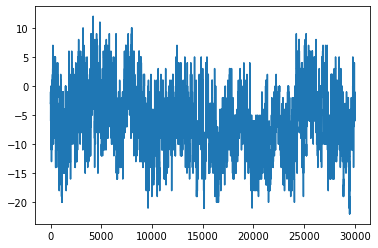

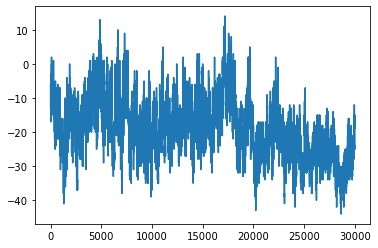

In [39]:
T = 200
e1, grids1 = monte_carlo_sim_polymer(Ns, N, M, T, grid1, rigid_move_polymer, fill_grid_list=True)
print(2)
print(3)
e2, grids2 = monte_carlo_sim_polymer(Ns, N, M, T, grid2, medium_flex_move, fill_grid_list=True)
plt.plot(e1)
plt.show()
plt.plot(e2)


<table><tr>
<td> <img src="animations/polymer_anim_0.png" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="animations/polymer_anim.gif" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="animations/polymer_anim_1.png" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>



In [21]:
# plt.plot(e1)
# plt.show()
# plt.plot(e2)

## Aggregate formation <a class="anchor" id="aggregate"></a>

In [22]:
def average_dL_sim(N, M, T, lengths, s=1/200, C=10000, t_max=100000, n=100, t_r=1000, move_function = medium_flex_move):
    avg_distL = np.zeros(len(lengths), dtype="float64")
    std_dev   = np.zeros(len(lengths), dtype="float64")
    for j in tqdm(range(len(lengths))):
        L = lengths[j]
        grid = generate_grid_of_polymers(N, M, L)
        t_equil = t_max * np.exp(-s*(T - 100)) + C # REF TEMP 100 CHEDK LATER
        Ns = int(t_equil)
        monte_carlo_sim_polymer(Ns, N, M, T, grid, move_function)
        dL_avg = np.zeros(n, dtype="float64")
        for i in range(n):
            monte_carlo_sim_polymer(t_r, N, M, T, grid, move_function)
            dL_avg[i] = 2*M/(get_cluster_grid(grid)[1]) # FORKLARE (2ML)/(#cluster*L)
            
        avg_distL[j] = sum(dL_avg) / n
        std_dev[j]  = np.std(dL_avg)
    return avg_distL, std_dev

# lengths = np.linspace(3, 39, 13).astype(int)
# T = 300
# N = 30
# M = 5
#avg_distL, std_dev = average_dL_sim(N, M, T, lengths)
#np.savez('data/average_dL_sim.npz', avg_distL=avg_distL, std_dev=std_dev)

lengths = np.linspace(3, 39, 13).astype(int)
T = 300
N = 25
M = 4
avg_distL, std_dev = average_dL_sim(N, M, T, lengths)
np.savez('data/TEST.npz', avg_distL=avg_distL, std_dev=std_dev)


  0%|          | 0/13 [00:00<?, ?it/s]

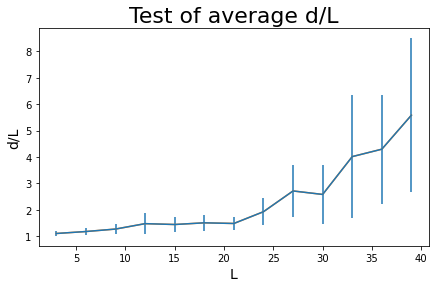

<Figure size 504x288 with 0 Axes>

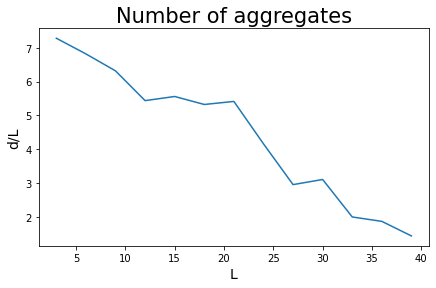

In [23]:
data = np.load('data/average_dL_sim.npz')
a_distL = data['avg_distL']
s_dev   = data['std_dev']
plot_function([lengths], [a_distL], 'Test_of_average_dL', errorbars = s_dev, title = "Test of average d/L", 
                  xlabel = "L", ylabel = "d/L", fig_size = (7, 4), title_scale_factor = 60)
plt.show()
plot_function([lengths], [2*M/a_distL], 'Number_of_aggregates', title = "Number of aggregates", 
                  xlabel = "L", ylabel = "d/L", fig_size = (7, 4), title_scale_factor = 60)

In [24]:
# Ns = 10000
# L = 39
# grid = generate_grid_of_polymers(N, M, L)
# e, grids = monte_carlo_sim_polymer(Ns, N, M, T, grid, medium_flex_move, fill_grid_list=True)
# plt.plot(e)
# print()

In [25]:
# visualize_grid(grids[0])
# visualize_grid(grids[-1])

**Ola sin gode forklaring ...**

$\overline{d/L} = \frac{2 L M}{N_c} / L = \frac{2 M }{N_c}$ Hvor $N_c$ er antallet clusters. Det gir $N_c = \frac{2M}{\overline{d/L}}$. Plot av $N_c$ viser hvordan antallet synker med økende $L$.

### Varying AAAAAAAAAAAAA DIFERENT PARAMMMMMM

Vi varierer a

## Conclusion <a class="anchor" id="conclusion"></a>

We have seen
we have shown blablabla